In [1]:
import pandas as pd
import sys
import os.path
import pickle
import time
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Load
Read the file resulting from the scraping:

In [2]:
# Location of the dataframe pickle file containing all the boat data:
boats_df_path = './data/boats_df.pkl'
if os.path.isfile(boats_df_path):
    df = pd.read_pickle(boats_df_path)
    print(len(df),' boats read from file into boats_df.')

3001  boats read from file into boats_df.


In [3]:
df.head()

,price,make,model,year,cls,length_ft,LOA_ft,displacement_lb,fuel_type,power_hp,eng_make,eng_model,eng_year,eng_hrs,location
5637501,Request Price,Bali,4.5,2020,Catamaran,45,45 ft,32800,Diesel,50,None,None,2016,50,"All Locations, California"
7213466,89500,Beneteau,OC 400,1996,Sloop,40,40 ft,19200,Diesel,None,Perkins,M-50,None,None,"Kenosha , Wisconsin"
7216014,125900,Hunter,466,2002,Cruiser (Sail),46,46 ft 1 in,26180,Diesel,76,Yanmar,None,2002,938,"Stamford, Connecticut"
7191853,265000,Jeanneau,Sun Odyssey 419,2018,Cruiser (Sail),42,41 ft 10 in,None,Diesel,45,Yanmar,None,None,300,"Portsmouth, Rhode Island"
7152732,388900,Fountaine Pajot,Orana 44,2012,Multi-Hull,44,44 ft,None,Diesel,None,Volvo Penta,D2-40,2012,5270,"St Thomas, United States"


I'm going to rename the feature 'year' to 'year_str'

In [4]:
df.rename(columns={'year':'year_str'},inplace=True)
df.rename(columns={'price':'price_str'},inplace=True)

# Clean
Clean steps to prepare the data for modeling:

In [5]:
# There are no null values in the year so it simply be converted to an int:
df['year'] = df['year_str'].astype(int).copy()
df['price'] = pd.to_numeric(df['price_str'],errors='coerce').copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3001 entries, 5637501 to 1015053
Data columns (total 17 columns):
price_str          3001 non-null object
make               3001 non-null object
model              2948 non-null object
year_str           3001 non-null object
cls                3001 non-null object
length_ft          3001 non-null object
LOA_ft             2709 non-null object
displacement_lb    1466 non-null object
fuel_type          2893 non-null object
power_hp           2086 non-null object
eng_make           2170 non-null object
eng_model          1587 non-null object
eng_year           1369 non-null object
eng_hrs            1118 non-null object
location           3001 non-null object
year               3001 non-null int64
price              757 non-null float64
dtypes: float64(1), int64(1), object(15)
memory usage: 422.0+ KB


Grab the parts of df that will be modeled and eliminate rows that have None's.

In [7]:
data = df.loc[:,['year','price']].copy()
data.dropna(inplace=True)
X = data[['year']]
y = data['price']

In [8]:
# Divide the data into test and train sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [9]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
fit = lr.fit(pd.DataFrame(X_train), y_train)

# Calculate R2 for the training set
y_pred_train = fit.predict(pd.DataFrame(X_train))
r2_train = fit.score(pd.DataFrame(X_train),y_train)

# Calculate y_pred and R2 for the test set
y_pred = fit.predict(pd.DataFrame(X_test))
r2_test = fit.score(pd.DataFrame(X_test),y_test)

In [10]:
r2_train = fit.score(pd.DataFrame(X_train),y_train)
y_pred_test = fit.predict(X_test)
y_pred_train = fit.predict(X_train)
r2_test = fit.score(X_test,y_test)
resid_train = y_train - y_pred_train
resid_test = y_test - y_pred_test

In [11]:
print('RMSE_train: ',round(mean_squared_error(y_train, y_pred_train)**0.5))
print('RMSE_test: ',round(mean_squared_error(y_test, y_pred_test)**0.5))

RMSE_train:  162241.0
RMSE_test:  118022.0


In [12]:
import matplotlib.ticker as ticker

R2 Train:  0.263
R2 Test:  0.426


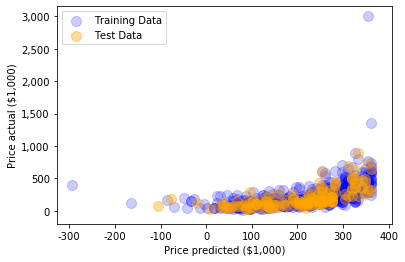

In [13]:
#Plot the results
fig,ax = plt.subplots(1,1);
ax.scatter(y_pred_train/1000,y_train/1000,label='Training Data', s=100, alpha=0.2, color='Blue')
ax.scatter(y_pred_test/1000,y_test/1000,label='Test Data', s=100, alpha=0.4, color='Orange')
#ax.semilogy()
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Price actual ($1,000)')
ax.set_xlabel('Price predicted ($1,000)')
ax.legend();
fig.savefig('./images/MVPActByPred.svg', format='svg', dpi=1200)
print('R2 Train: ', round(r2_train,3))
print('R2 Test: ', round(r2_test,3))

This was the MVP linear regression.

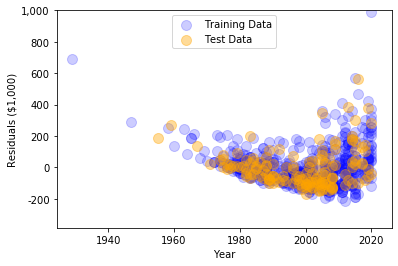

In [14]:
#Plot Residual by Year
fig,ax = plt.subplots(1,1);
ax.scatter(X_train.year,resid_train/1000,label='Training Data', s=100, alpha=0.2, color='Blue')
ax.scatter(X_test.year,resid_test/1000,label='Test Data', s=100, alpha=0.4, color='Orange')
ax.set_ylim(top=1000)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Residuals ($1,000)')
ax.set_xlabel('Year')
ax.legend(loc='upper center');
fig.savefig('./images/MVPResByYear.svg', format='svg', dpi=1200)

$Price = f(year)$